# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from SSMF import *
from general_utils import *
from visualization_utils import * 
from dsp_utils import *
from bss_utils import *
from numba_utils import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'RVolMin'

# Source Generation and Mixing Scenario

In [3]:
N = 10000
NumberofSources = 5
NumberofMixtures = 10
S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)
# Generate Mxr random mixing from i.i.d N(0,1)
# A = np.random.randn(NumberofMixtures,NumberofSources)
A = np.random.uniform(0,1, (NumberofMixtures,NumberofSources))
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.006569784434678


# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 5000
model = RVolMin(s_dim = s_dim, x_dim = x_dim,
                set_ground_truth = True, S = S, A = A)

# Run RVolMin Algorithm on Mixture Signals

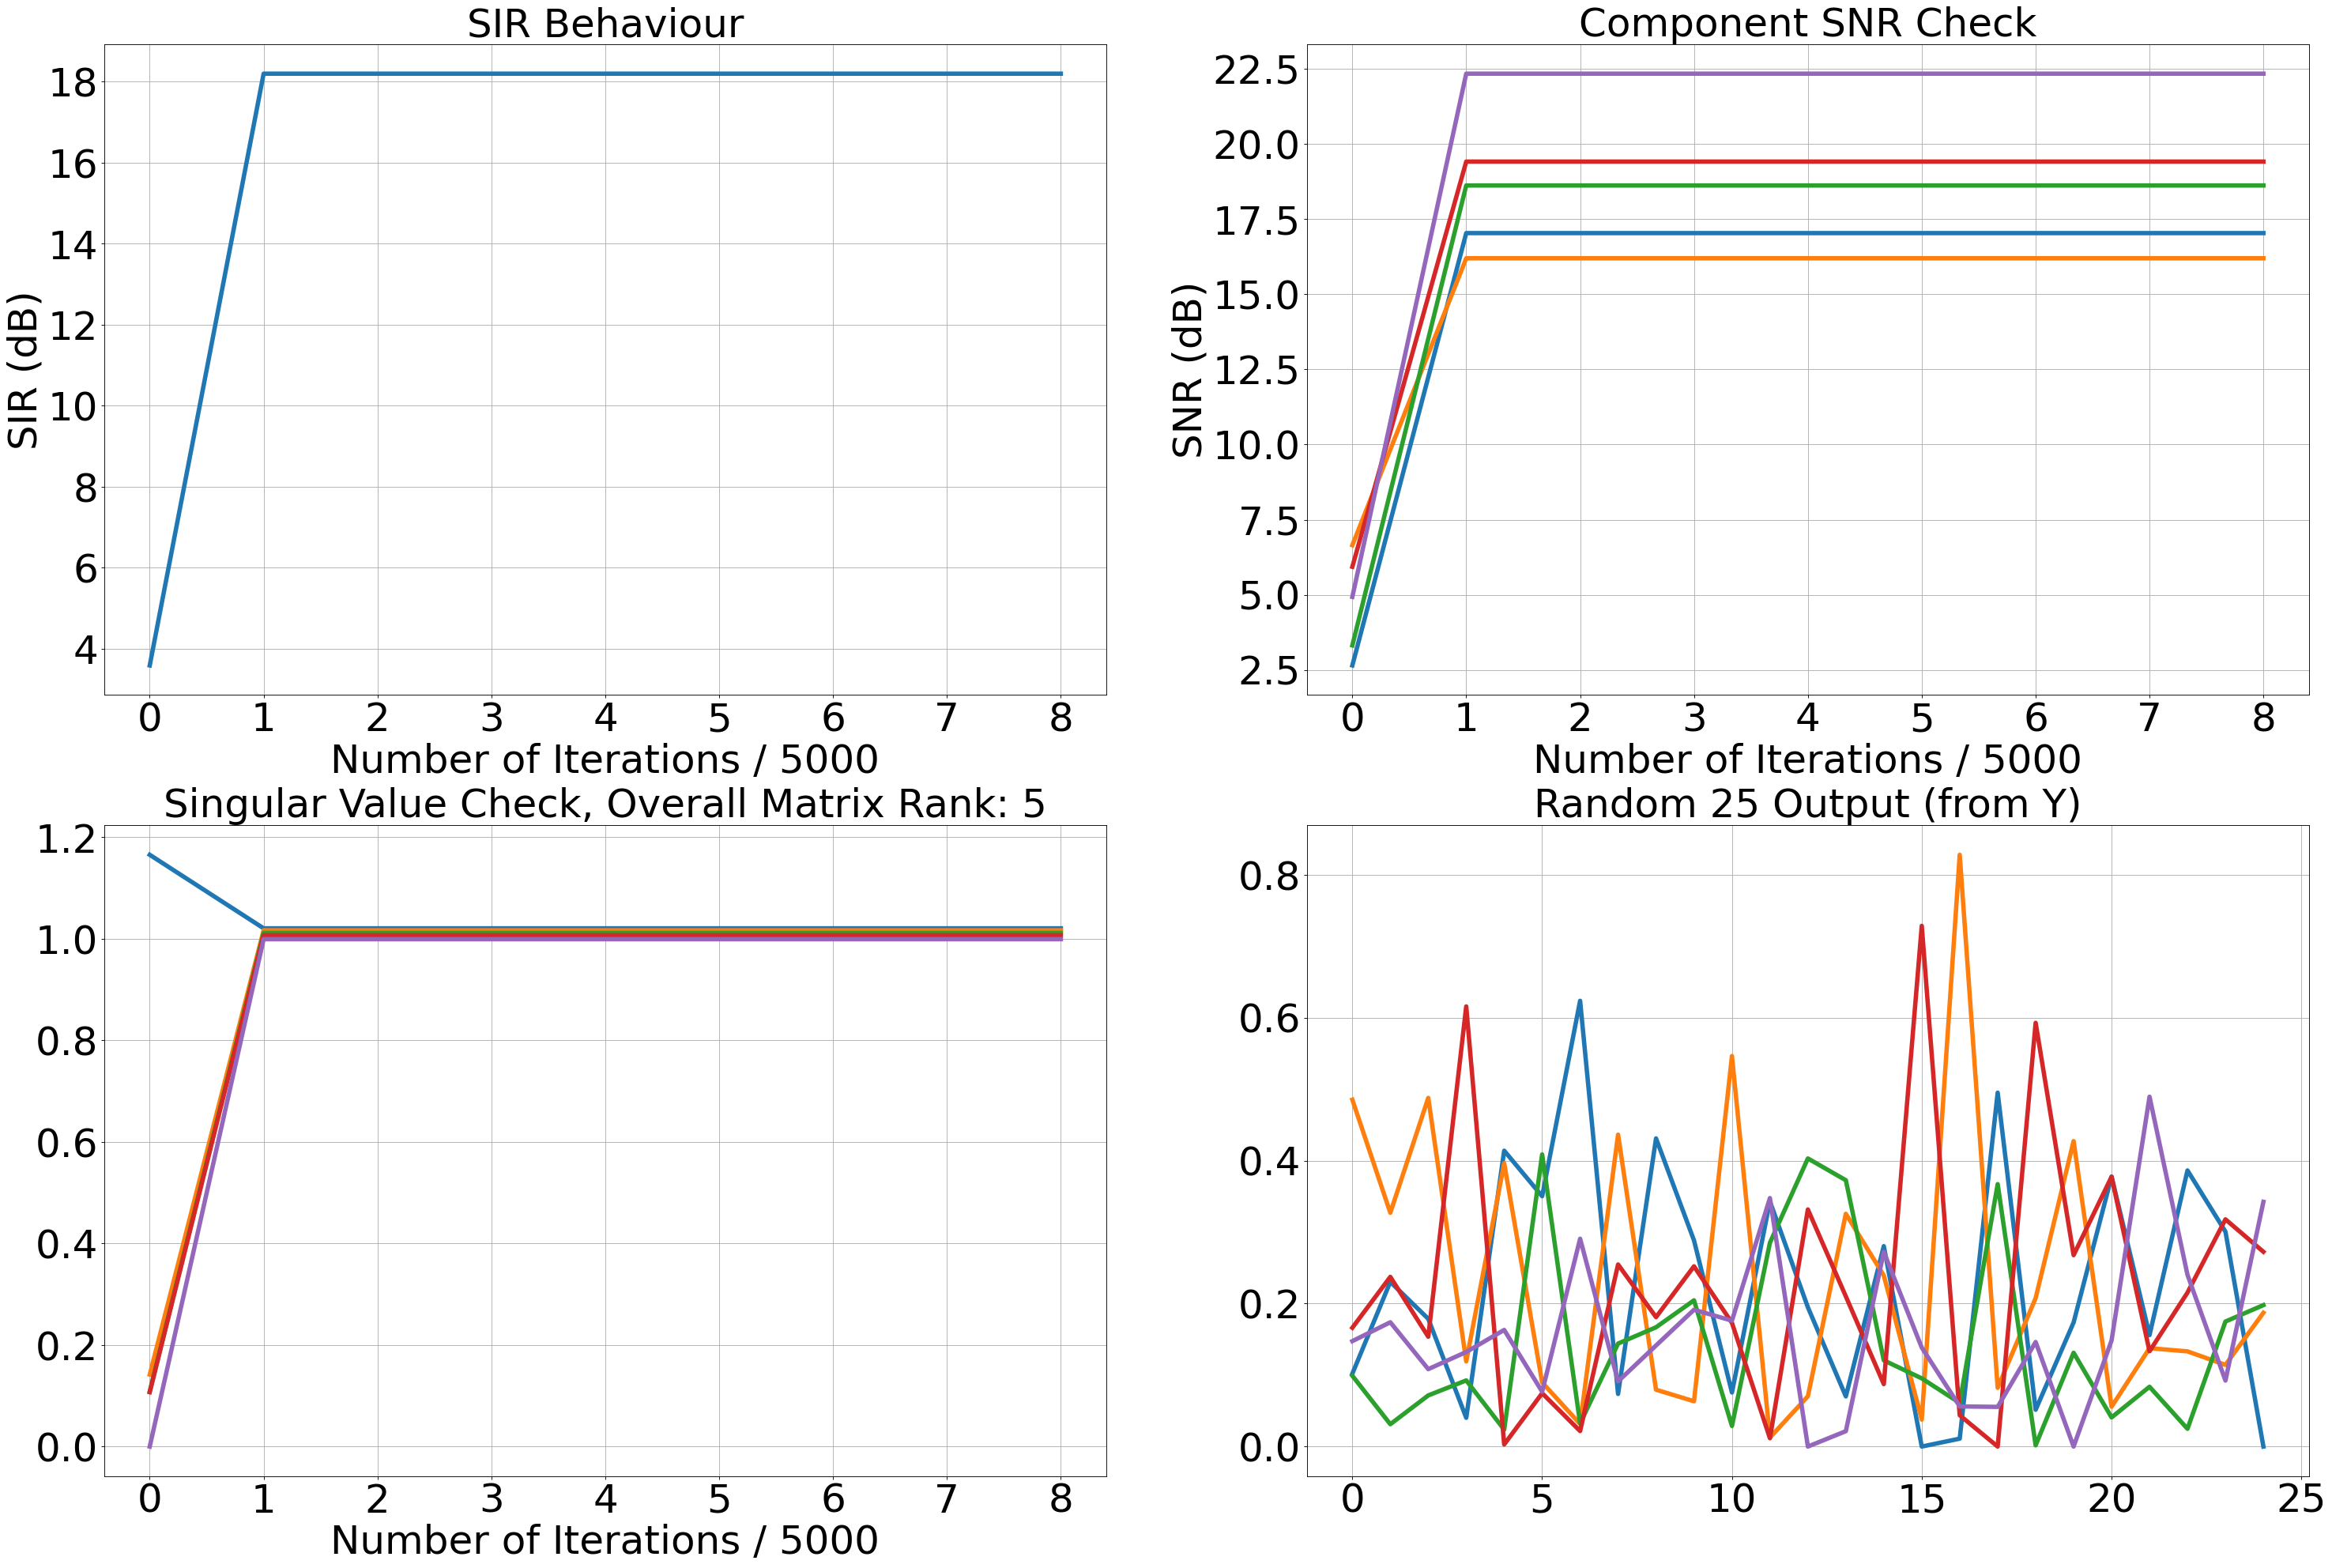

100%|██████████| 40000/40000 [02:32<00:00, 262.79it/s]


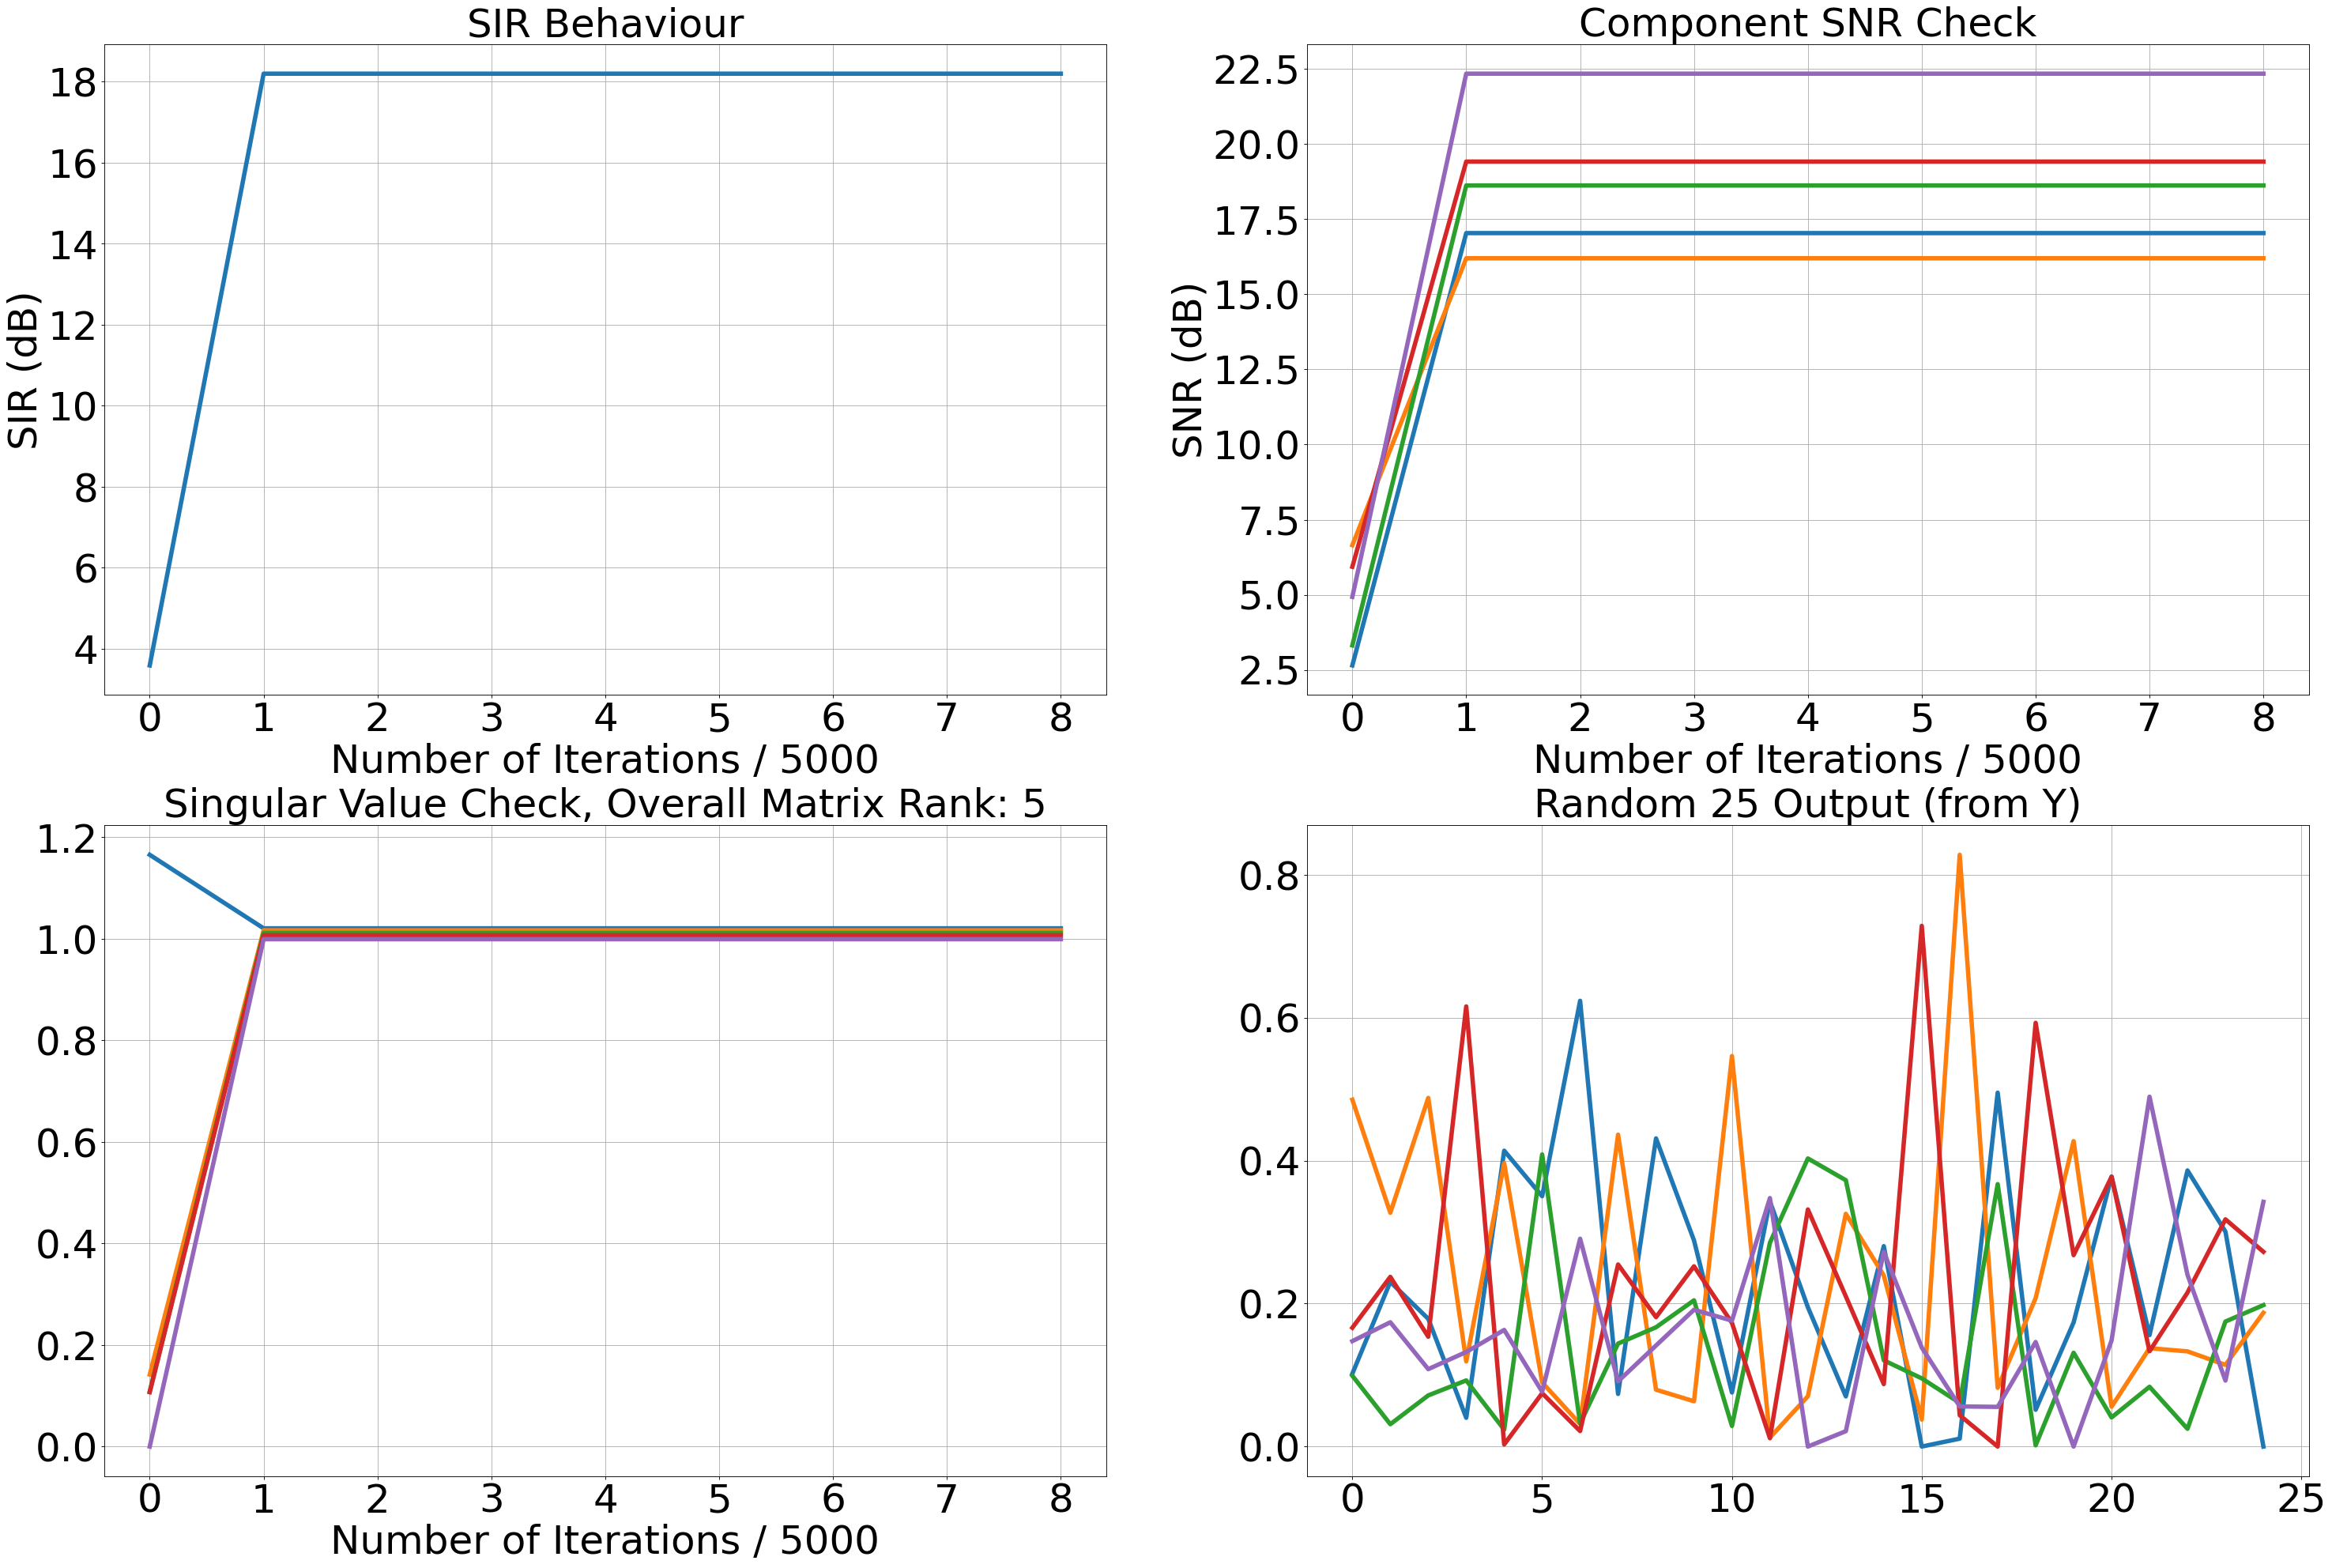

In [5]:
model.fit_batch(X, n_iterations = 40000,
                Lt = 50, p = 1.9, lambda_ = 0.9,
                debug_iteration_point = debug_iteration_point,
                plot_in_jupyter = True)

# Calculate Resulting Component SNRs and Overall SINR

In [6]:
Szeromean = S - S.mean(axis = 1).reshape(-1,1)
Wf = model.Wseparator
Y_ = Wf @ X
Yzeromean = Y_ - Y_.mean(axis = 1).reshape(-1,1)
Y_ = model.signed_and_permutation_corrected_sources(Szeromean,Yzeromean)
coef_ = ((Y_ * Szeromean).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(Szeromean, Y_)))

SINR = 10*np.log10(CalculateSINRjit(Y_, Szeromean, False)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [18.49018832 16.31485436 15.50314614 19.2940634  19.64065528]

Overall SINR : 17.479017968789343
